<a href="https://colab.research.google.com/github/tommyj530/DisguiseFaceRecognition/blob/main/competition_main_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install gitpython
!pip install h5py
!python -m pip install sktime --user
!python -m pip install pyts --user
!python -m pip install tslearn
!pip install tsfel

# Importing Libraries 

In [72]:
import os
import glob
import pandas as pd
import numpy as np
import sklearn
from scipy import signal
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_validate
import torch
from torch import nn
import matplotlib.pyplot as plt
import git
from os import listdir 
from keras.preprocessing import sequence 
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM
from keras.optimizers import Adam 
from keras.models import load_model 
from keras.callbacks import ModelCheckpoint 
import keras
import h5py
import scipy


# Unzipping the dataset 

In [73]:
# train_meta contains filenames of training data and corresponding labels
from zipfile import ZipFile 
file_name = "Competition (2).zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Dataset Observation 

In [74]:
path = "Competition"
train_meta = pd.read_csv(path + '/train_meta.txt', delimiter = ' ', header=None, names=['filename', 'labels'])
train_meta['labels'] = train_meta['labels'].str.replace('[','')
train_meta['labels'] = train_meta['labels'].str.replace(']','')
train_meta['labels'] = train_meta.labels.apply(pd.to_numeric, errors='coerce')
train_meta['labels'] = pd.to_numeric(train_meta.labels, errors='coerce')

print(train_meta)
labels = np.array(train_meta.labels)
print(labels)





                   filename  labels
0     /train/GiLImBvDWs.csv       5
1     /train/VQEyZLyBMp.csv       5
2     /train/AdgWYaoORE.csv       5
3     /train/lKhsadfBkL.csv       5
4     /train/DKwGHgrHLG.csv       5
...                     ...     ...
1345  /train/KmaBQPpvuV.csv       0
1346  /train/THvCkkaZzj.csv       0
1347  /train/kqdPRRxErl.csv       0
1348  /train/XMCflmfeyQ.csv       0
1349  /train/SEHrRlwCzK.csv       0

[1350 rows x 2 columns]
[5 5 5 ... 0 0 0]


# Raw Data Graph

*   Graph the time-series data from each of the 9 channels and observe its behavhior
*   Look at the frequency properties of the time-series data: we can get a better sense of what filters to use based on its frequecny content


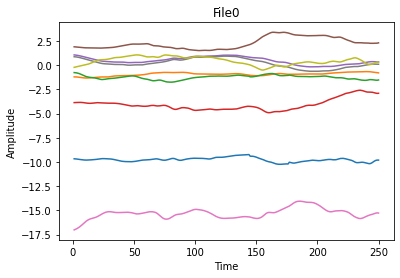

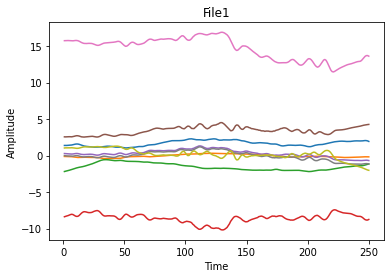

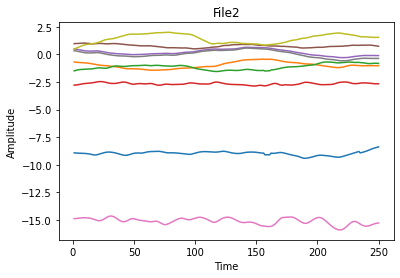

In [75]:
# check if balanced dataset
# train_meta.labels.value_counts()

# Adding data to train_meta 
# [file1], [file2], ...
num_list = []
for i in train_meta['filename']:
  temp_list = np.genfromtxt(path + i)
  num_list.append(np.transpose(temp_list))


# Visualizing the raw data for the first 5 files
for i in range(3):
  for j in range(len(num_list[1])):
    x_axis = list(range(1,251))
    plt.plot(x_axis, num_list[i][j])
  plt.title('File' + str(i))
  plt.xlabel('Time') 
  plt.ylabel('Amplitude') 
  plt.show()


# Normalized Data Graph
Let us normalize the time-series data from each channel since the model is sensitive to the actual values

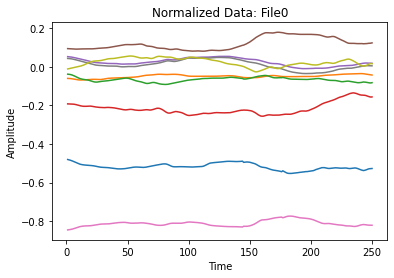

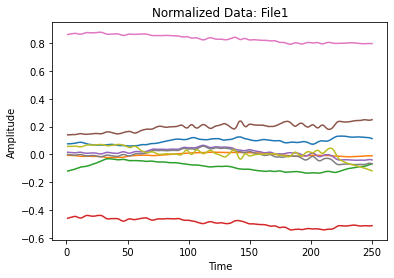

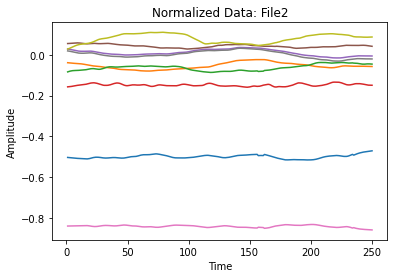

In [76]:
# Normalize data in each channel in each file
X = [] #(#files, #timestep, #features)
num_normal_list = []
for i in train_meta['filename']:
  temp_list = np.genfromtxt(path + i)
  temp_list1 = np.transpose(temp_list)
  
  temp_list = sklearn.preprocessing.normalize(temp_list, axis=0)
  temp_list1 = sklearn.preprocessing.normalize(temp_list1, axis=0)

  X.append (temp_list)
  num_normal_list.append(temp_list1)

# Visualizing the normalized data
for i in range(3):
  for j in range(len(num_normal_list[1])):
    x_axis = list(range(1,251))
    plt.plot(x_axis, num_normal_list[i][j])
  plt.title('Normalized Data: File' + str(i))
  plt.xlabel('Time') 
  plt.ylabel('Amplitude') 
  plt.show()

train_meta['features'] = num_normal_list
#print(len(train_meta.features))


# Frequnecy Response of Raw Data via FFT
*   Based on frequency analysis, the raw data is quite clean. Just put it through a LPF


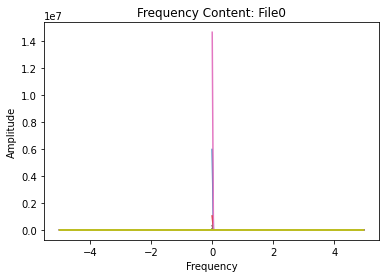

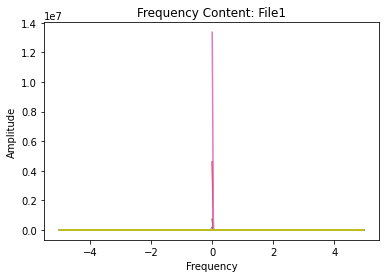

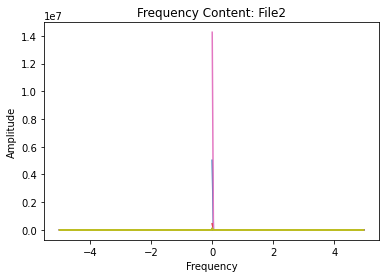

In [77]:
# FFT of the time-series data 
# for a single time-series data
'''
i = '/train/GiLImBvDWs.csv'
temp_list = np.genfromtxt(path + i)
temp_list = np.transpose(temp_list)
temp_list = np.fft.fft(temp_list)
xf = np.fft.fftfreq(temp_list.shape[1],d=1)
plt.plot(xf,temp_list[6])
plt.title('Frequency Content')
plt.xlabel('Freq') 
plt.ylabel('Amplitude') 
plt.show()

print(temp_list.shape[1])
'''

# looping for visualize others
num_fft_list = []
for i in train_meta['filename']:
  temp_list = np.genfromtxt(path + i)
  temp_list = np.transpose(temp_list)
  temp_list = np.fft.fft(temp_list, axis=1)
  num_fft_list.append(temp_list)

# Visualizing the frequency content
for i in range(3):
  for j in range(len(num_fft_list[1])):
    xf = np.fft.fftfreq(temp_list.shape[1],d=0.1)
    plt.plot(xf, np.abs(num_fft_list[i][j])**2)
  plt.title('Frequency Content: File' + str(i))
  plt.xlabel('Frequency') 
  plt.ylabel('Amplitude') 
  plt.show()

No high frequency content. No need for filtering. The data is already pretty clean.

# Spectogram to reveal frequency and temporal information


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=250).


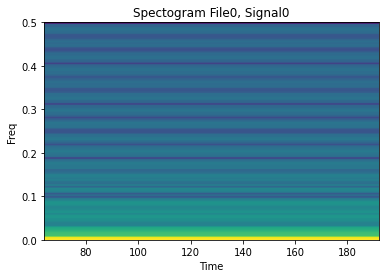

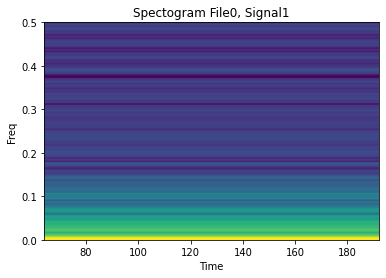

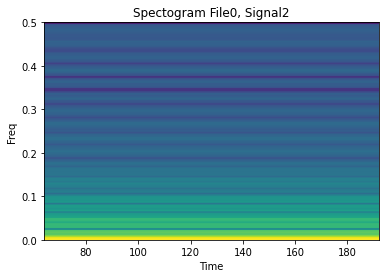

In [78]:
num_spec_list = []
for i in train_meta['filename']:
  temp_list = np.genfromtxt(path + i)
  temp_list = np.transpose(temp_list)
  num_spec_list.append(temp_list)

# for a single array 
'''
print(num_spec_list[0][0])
print(type(np.array(num_spec_list[0][0][1])))
NFFT = 256  # the length of the windowing segments
Fs = 1
Pxx, freqs, bins, im  = plt.specgram(num_spec_list[0][0], NFFT=NFFT, Fs=Fs)
'''

NFFT = 256  # the length of the windowing segments
Fs = 1
# looping to get a spectogram for all signals in one file
for i in range(1):
  for j in range(len(num_spec_list[1])-6):
    Pxx, freqs, bins, im  = plt.specgram(num_spec_list[i][j], NFFT=NFFT, Fs=Fs)
    plt.title('Spectogram File' + str(i) + ', Signal' + str(j))
    plt.xlabel('Time') 
    plt.ylabel('Freq') 
    plt.show()

No need to extract frequency/temporal features as a spectogram from time-series data. USE STATISTICAL FEATURES!

# Method 1: LSTM
https://blog.edugrad.com/introduction-to-time-series-classification-in-python/

Splitting dataset into train and test within the test data for validation: since the dataset is small, the splitting ratio is more favoured toward training so the model can better learn with a slightly larger dataset

In [90]:
from sklearn.model_selection import train_test_split
from __future__ import division
from pandas import DataFrame, concat
import itertools
from math import floor, ceil
from numpy import random
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score
import matplotlib.pyplot as plt
from keras import optimizers
from keras.optimizers import SGD, RMSprop, Adam, schedules
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input, Activation, Bidirectional, Dropout
from keras.utils import to_categorical
from xgboost import XGBClassifier
from keras import Sequential

split_ratio = 0.9 
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=42)

X_train = np.array(X_train) 
X_test = np.array(X_test)
print(X_train.shape)

(1215, 250, 9)


In [80]:
y_train

array([10,  7,  6, ...,  0,  6,  2])

In [81]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print(Y_train.shape)
print(Y_test.shape)


(1215, 15)
(135, 15)


In [82]:
print(X_train.shape)
print(y_train.shape)


(1215, 250, 9)
(1215,)


In [125]:
# Define LSTM
BATCH_SIZE = 16
nb_classes = 15
nb_timesteps = 250
nb_feat = 9

'''
# With custom backward layer
model = Sequential()
forward_layer = LSTM(10, return_sequences=True)
backward_layer = LSTM(10, activation='relu', return_sequences=True,
                       go_backwards=True)
model.add(Bidirectional(forward_layer, backward_layer=backward_layer,
                         input_shape=(5, 10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
'''

# try different activiation functions 
# add a dropout 
# different batch size 
# reduce the number of features using PCA '

#model.add(Flatten())
#model.add(Dense(1))
#metrics= ['accuracy']


# linear activation does works terribly 
# sigmoid and relu activation output similiar results
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(nb_timesteps, nb_feat)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# use either Adam or RMSprop 
# SGD works terrribly 
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics= ['accuracy'])
model.summary()

# Fit LSTM
EPOCH_SIZE = 50
model.fit(X_train, Y_train, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_67 (Bidirectio (None, 250, 128)          37888     
_________________________________________________________________
dropout_55 (Dropout)         (None, 250, 128)          0         
_________________________________________________________________
bidirectional_68 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_56 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 200)               13000     
_________________________________________________________________
dense_64 (Dense)             (None, 15)                3015      
Total params: 95,119
Trainable params: 95,119
Non-trainable params: 0
_________________________________________________

In [126]:

y_pred = np.argmax(model.predict(X_test),axis=1)
accuracy_score(y_test, y_pred)

0.6444444444444445

In [127]:
model.save('2LSTMLayers2DropoutReluSoftmax16Batch30Epochs65%accuracy.h5')
files.download('2LSTMLayers2DropoutReluSoftmax16Batch30Epochs65%accuracy.h5')

'''
# Loading the model
from google.colab import files
model = keras.models.load_model('Sigmoid2LSTMLayers4Batch50Epochs.h5')
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

"\n# Loading the model\nfrom google.colab import files\nmodel = keras.models.load_model('Sigmoid2LSTMLayers4Batch50Epochs.h5')\n"

In [ ]:
import numpy as np
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint

vec_size = 100
n_units = 10

x_train = np.random.rand(500, 10, vec_size)
y_train = np.random.rand(500, vec_size)

model = Sequential()
model.add(LSTM(n_units, input_shape=(None, vec_size), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_units, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(n_units))
model.add(Dropout(0.2))
model.add(Dense(vec_size, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# fit the model
model.fit(x_train, y_train, epochs=5, batch_size=50, callbacks=callbacks_list)

# load the model
new_model = load_model(filepath)
assert_allclose(model.predict(x_train),
                new_model.predict(x_train),
                1e-5)

# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(x_train, y_train, epochs=5, batch_size=50, callbacks=callbacks_list)

Save and load models

# PCA on raw data


In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
PrincipalComponents = []
for i in range(len(train_meta.features)):
  temp_list = pca.fit_transform(np.transpose(train_meta.features[i]))
  PrincipalComponents.append(temp_list)

# Distribution of variance along principal components
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
# 62%, 25%, 8% of total variance in the data lie in 1st, 2nd, and 3rd principal componenets 
# reduce the dimensionality by 3 or more 

# Checking the size of PrinicpalComponents array 
PrincipalComponents = np.array(PrincipalComponents)
#print(PrincipalComponents.shape)

# Let us use just the first principal component and see how the model performs
pca = PCA(n_components=1)
FirstPCs = []
for i in range(len(train_meta.features)):
  temp_list = pca.fit_transform(np.transpose(train_meta.features[i]))
  FirstPCs.append(np.transpose(temp_list))

# I want the data to be structed as follows:
# [file1] [file2]
# [[PCA1],[PCA2]]
# data structure before PCA
#(1350, 9, 250)

# Checking the size: only 1st PC should be there
FirstPCs = np.array(FirstPCs)
print(FirstPCs.shape)

for i in range(2):
  for j in range(len(FirstPCs[1])):
    x_axis = list(range(1,251))
    plt.plot(x_axis, num_normal_list[i][j])
  plt.title('1st PCA: File' + str(i))
  plt.xlabel('Time') 
  plt.ylabel('Amplitude') 
  plt.show()

In [ ]:
# Define LSTM
BATCH_SIZE = 16
nb_classes = 15
nb_timesteps = 250
nb_feat = 9

'''
# With custom backward layer
model = Sequential()
forward_layer = LSTM(10, return_sequences=True)
backward_layer = LSTM(10, activation='relu', return_sequences=True,
                       go_backwards=True)
model.add(Bidirectional(forward_layer, backward_layer=backward_layer,
                         input_shape=(5, 10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
'''

# try different activiation functions 
# add a dropout 
# different batch size 
# reduce the number of features using PCA '

#model.add(Flatten())
#model.add(Dense(1))
#metrics= ['accuracy']


# linear activation does works terribly 
# sigmoid and relu activation output similiar results
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(nb_timesteps, nb_feat)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# use either Adam or RMSprop 
# SGD works terrribly 
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics= ['accuracy'])
model.summary()

# Fit LSTM
EPOCH_SIZE = 50
model.fit(X_train, Y_train, epochs=EPOCH_SIZE, batch_size=BATCH_SIZE)